In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.core.display import HTML
import copy
from copy import deepcopy
import random

np.random.seed(1)

In [357]:
def PBC(R, L):
    """
    Apply periodic boundary conditions to particle positions
    in a cubic box of side length L.

    Parameters
    ----------
    R : np.array, shape (N, N, 3)
        particle positions
    L : float
        box side length

    Returns
    -------
    np.array, shape (N, N, 3) : particle positions after PBC
    """

    return R - L * np.round(R / L)


def actime(E):
    """
    Calculate the autocorrelation time for a time series E

    Args:
        E (np.array): array of energies, shape (N,)
    Returns:
        (float, int): (kappa, tcutoff), the autocorrelation time and the cutoff time
    """

    mu = np.mean(E)
    std = np.std(E, ddof=1)
    N = E.shape[0]
    ts = np.arange(0, N, 1)

    a_diffs = np.zeros((N, N))

    for t in ts:
        a_diffs[t][: N - t] = (E[: N - t] - mu) * (E[t:] - mu)

    autocorrelation = np.sum(a_diffs, axis=1) / std**2 / (N - ts)
    tcutoff = (
        np.where(autocorrelation <= 0)[0][0] if (autocorrelation <= 0).any() else 0
    )
    kappa = 1 + 2 * np.sum(autocorrelation[1:tcutoff])

    return autocorrelation, kappa, tcutoff


def KE(vel, mass):
    """
    Calculate total kinetic energy.

    Parameters
    ----------
    vel : np.array, shape (N, 3)
        particle velocities
    mass : float
        particle mass

    Returns
    -------
    float
        total kinetic energy
    """
    return np.sum(np.linalg.norm(vel) ** 2 / 2 * mass)


def totalMomentum(vel, mass):
    """
    Calculate total kinetic momentum.

    Args:
        vel (np.array): particle velocities, shape (nparticle, 3)
        mass (float): particle mass
    Returns:
        float: total momentum
    """

    return np.sum(vel * mass, axis=0)


def generateAcceptCheck(N):
    """
    Generate uniform random numbers for Monte Carlo acceptance checks

    Args:
        N (int): number of particles
    Returns:
        np.array: array of shape (N,) of uniform random numbers
    """

    return np.random.uniform(low=0, high=1, size=N)


def distance_alloy(R, L):
    """
    Compute distance table and rij vectors

    Parameters
    ----------
    R : np.array, shape (N, 3)
        particle positions
    L : float
        box side length

    Returns
    -------
    np.array, shape (N, N) : distance table
    np.array, shape (N, N, 3) : rij vectors
    """

    rij = R[:, np.newaxis, 0:3] - R[:, 0:3]
    rij = PBC(rij, L)
    distance_table = np.linalg.norm(rij, axis=2)

    return distance_table, rij


def distancei_alloy(i, R, L):
    """
    Compute distance table and rij vectors for a single particle

    Args:
        i (int): particle index
        R (np.array) : particle positions, shape (N, 3)
        L (float): side length of cubic box
    Returns:
        distance_table (np.array): distance table, shape (N, )
        rij (np.array): rij vectors, shape (N, 3)
    """

    rij = R[i, 0:3] - R[:, 0:3]
    rij = PBC(rij, L)
    distance_table = np.linalg.norm(rij, axis=1)
    # species = R[:, 3]

    return distance_table, rij


def initPositionFCC(Ncell, a):
    """
    Places atoms in a fcc box

    Args:
        Ncell (int): supercell dimension in cubic-wise
        a (float): lattice constant
    Returns:
        (float, float, np.array): (N, L, position)
    """
    import math

    L = Ncell * a

    rs = L / Ncell
    roffset = L / 2
    x = np.linspace(-L / 2, -L / 2 + a * (Ncell - 1), Ncell)
    x, y, z = np.meshgrid(x, x, x, indexing="ij")
    # Stack the edge positions
    position = np.column_stack((x.ravel(), y.ravel(), z.ravel()))

    # Stack the 3 face-positions
    xx = np.column_stack(
        (position[:, 0] + a / 2, position[:, 1] + a / 2, position[:, 2])
    )
    xx = np.delete(xx, np.where((xx > roffset))[0], axis=0)
    yy = np.column_stack(
        (position[:, 0] + a / 2, position[:, 1], position[:, 2] + a / 2)
    )
    yy = np.delete(yy, np.where((yy > roffset))[0], axis=0)
    zz = np.column_stack(
        (position[:, 0], position[:, 1] + a / 2, position[:, 2] + a / 2)
    )
    zz = np.delete(zz, np.where((zz > roffset))[0], axis=0)

    position_new = np.row_stack((position, xx, yy, zz))
    N = position_new.shape[0]

    return N, L, position_new


def initVelocity(N, T0, mass=1.0, seed=1):
    """
    Initialize velocities from a Maxwell-Boltzmann distribution

    Args:
        N (int): number of particles
        T0 (float): temperature
        mass (float): particle mass
        seed (int): random seed
    Returns:
        np.array: velocities, shape (N, 3)
    """

    dim = 3
    np.random.seed(seed)
    # generate N x dim array of random numbers, and shift to be [-0.5, 0.5)
    velocity = np.random.random((N, dim)) - 0.5
    # get the average along the first axis
    meanV = np.sum(velocity, axis=0) / N
    # subtract off meanV, so there is no net momentum
    velocity -= meanV
    # calculate the total of V^2
    ke = np.sum(velocity * velocity)
    # calculate a scaling factor
    vscale = np.sqrt(dim * N * T0 / (mass * ke))
    # rescale
    velocity *= vscale

    return velocity


def initVelocityHydrogen(N, T0, mass=1.0, seed=1):
    dim = 3
    np.random.seed(seed)
    # generate N x dim array of random numbers, and shift to be [-0.5, 0.5)

    velocity = np.random.random((N, dim)) - 0.5
    # calculate the total of V^2
    ke = np.sum(velocity * velocity)
    # calculate a scaling factor
    vscale = np.sqrt(dim * N * T0 / (mass * ke))
    # rescale
    velocity *= vscale

    return velocity


def verletNextR(r_t, v_t, a_t, h):
    """
    Return new positions after one Verlet step

    Args:
        r_t (np.array): positions at time t, shape (nparticles, ndim)
        v_t (np.array): velocities at time t, shape (nparticles, ndim)
        a_t (np.array): accelerations at time t, shape (nparticles, ndim)
        h (float): timestep
    Returns:
        np.array: positions at time t+h, shape (nparticles, ndim)
    """

    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    r_t_plus_h = r_t + v_t * h + 0.5 * a_t * h * h

    return r_t_plus_h


def verletNextV(v_t, a_t, a_t_plus_h, h):
    """
    Return new velocities after one Verlet step

    Args:
        v_t (np.array): velocities at time t, shape (nparticles, ndim)
        a_t (np.array): accelerations at time t, shape (nparticles, ndim)
        a_t_plus_h (np.array): accelerations at time t+h, shape (nparticles, ndim)
        h (float): timestep

    Returns:
        np.array: velocities at time t+h, shape (nparticles, ndim)
    """

    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    v_t_plus_h = v_t + 0.5 * (a_t + a_t_plus_h) * h

    return v_t_plus_h


def LJi(i, distance_table, rc, self, A, B):
    """
    Compute shifted Leonord Jones potential energy for particle i

    Args:
        i (int): particle index
        distance_table (np.array): single particle distance table, shape (N, )
        L (float): cubic box side length
        rc (float): potential cutoff radius
    Return:
        pe (float): potential energy for particle i
    """

    sixth_rc = rc**-6
    vshift = A * sixth_rc**2 - B * sixth_rc
    rc_mask = distance_table < rc
    if self > 0:
        i_mask = np.arange(distance_table.shape[0]) != i
        mask = rc_mask & i_mask
    else:
        mask = rc_mask
    sixth = distance_table[mask] ** -6
    pe = np.sum(A * sixth**2 - B * sixth - vshift)

    return pe


def LJ(distance_table, rc, A, B):
    sixth_rc = rc**-6
    vshift = A * sixth_rc**2 - B * sixth_rc

    n = distance_table.shape[0]
    i_mask = np.triu(np.ones((n, n), dtype=bool), k=1)
    rc_mask = distance_table < rc
    mask = i_mask & rc_mask
    r = distance_table[mask]
    sixth = r**-6
    v = A * sixth**2 - B * sixth

    return np.sum(v - vshift)


def LJ_hydrogen(distance_table, rc, A, B):
    sixth_rc = rc**-6
    vshift = A * sixth_rc**2 - B * sixth_rc

    n = distance_table.shape[0]
    rc_mask = distance_table < rc
    mask = rc_mask
    r = distance_table[mask]
    sixth = r**-6
    v = A * sixth**2 - B * sixth

    return np.sum(v - vshift)


def LJForcei(rij, distance_table, rc, A, B):
    n = rij.shape[0]
    rc_mask = distance_table >= rc
    distance_table[rc_mask] = np.inf
    force = 12 * A * distance_table**-13 - 6 * B * distance_table**-7
    force = force[:, :, np.newaxis]
    forcei = np.sum(force * rij, axis=0)
    forcej = np.sum(force * rij, axis=1)
    # force = np.row_stack((forcej,forcei))

    return forcej, forcei


def LJForce(rij, distance_table, rc, A, B):
    n = rij.shape[0]
    i_mask = ~np.eye(n, dtype=bool)
    rij = rij[i_mask].reshape(n, -1, 3)  # Remove self-interaction
    distance_table = distance_table[i_mask].reshape(n, -1)  # Remove self-interaction
    rc_mask = distance_table >= rc
    distance_table[rc_mask] = np.inf
    force = 12 * A * distance_table**-13 - 6 * B * distance_table**-7
    force = force[:, :, np.newaxis]
    force = np.sum(force * rij, axis=1)

    return force


def LJForceHydrogen(rij, distance_table, rc, A, B):
    n = rij.shape[0]
    rc_mask = distance_table >= rc
    distance_table[rc_mask] = np.inf
    force = 12 * A * distance_table**-13 - 6 * B * distance_table**-7
    net_force = np.dot(force, rij)
    force = rij.T * force
    return net_force, -force.T


def mcSwapMetropolis_FCC(R, L, rc, beta, accept_check, Ams, Bms, Asol, Bsol):
    """Perform one Monte Carlo sweep

    Args:
        R (np.array): particle positions, shape (N, d)
        L (float): cubic box side length
        rc (float): potential cutoff radius
        beta (float): inverse temperature
        eta (np.array): shape (N, d), array of Gaussian random numbers, one for each single-particle move
        accept_check (np.array): shape (natom), array of uniform random numbers, one for each single particle move
    Return:
        (int, float): (naccept, dR), the number of accepted single-particle moves, and the change in energy
    """
    R = deepcopy(R)
    naccept = 0
    dE = 0
    Rmat = np.delete(R, np.where((R[:, 3] < 0))[0], axis=0)
    Rsol = np.delete(R, np.where((R[:, 3] > 0))[0], axis=0)
    Nmat, dmat = Rmat.shape
    Nsol, dsol = Rsol.shape
    R = np.row_stack((Rmat, Rsol))

    for i in range(Nsol):
        distance_table, rij = distancei_alloy(Nmat + i, R, L)

        PE_oldij = LJi(i, distance_table[0:Nmat], rc, -5, Ams, Bms)
        PE_oldjj = LJi(i, distance_table[Nmat : Nmat + Nsol], rc, 5, Asol, Bsol)
        PE_old = PE_oldij + PE_oldjj

        nR = copy.deepcopy(R)
        chg_ind = random.sample(range(0, Nmat), 1)
        a = copy.deepcopy(nR[Nmat + i, 0:3])
        b = copy.deepcopy(nR[chg_ind, 0:3])
        nR[Nmat + i, 0:3] = b
        nR[chg_ind, 0:3] = a
        distance_new, rij_new = distancei_alloy(Nmat + i, nR, L)
        PE_newij = LJi(i, distance_new[0:Nmat], rc, -5, Ams, Bms)
        PE_newjj = LJi(i, distance_new[Nmat : Nmat + Nsol], rc, 5, Asol, Bsol)
        PE_new = PE_newij + PE_newjj

        dEi = PE_new - PE_old
        # kb = 0.0019872041  # kcal/mol/K
        # p = -beta * dEi/kb
        p = -beta * dEi
        if dEi <= 0 or accept_check[i] <= np.exp(p):
            # if p > np.log(accept_check[i]):
            R = nR
            naccept += 1
            dE += dEi

    return naccept, dE, R


def simulateMcMetropolis_FCC(
    Ncell, a, T, rc, sigma, steps, Amat, Bmat, Ams, Bms, Asol, Bsol, composition
):
    beta = 1 / T
    N, L, R = initPositionFCC(Ncell, a)
    Nsol = int(np.round(N * composition))
    list_sol = random.sample(range(0, N), Nsol)
    list_total = np.ones((N,), dtype=int)
    list_total[list_sol] = -1
    R = np.column_stack((R, list_total))
    Rs = np.zeros((steps, N, 4))
    Es = np.zeros(steps)
    distances = np.zeros((steps, N, N))
    acceptance_ratios = np.zeros(steps)

    Rmat = np.delete(R, np.where((R[:, 3] < 0))[0], axis=0)
    Rsol = np.delete(R, np.where((R[:, 3] > 0))[0], axis=0)
    Nmat, dmat = Rmat.shape
    R = np.row_stack((Rmat, Rsol))

    Rs[0] = R
    distance_table, rij = distance_alloy(R, L)
    E_ii = LJ(distance_table[0:Nmat, 0:Nmat], rc, Amat, Bmat)
    E_jj = LJ(distance_table[Nmat : Nmat + Nsol, Nmat : Nmat + Nsol], rc, Asol, Bsol)
    E_ij = LJi(
        1, np.ravel(distance_table[0:Nmat, Nmat : Nmat + Nsol]), rc, -5, Ams, Bms
    )
    E0 = E_ii + E_ij + E_jj
    Es[0] = E0

    for t in range(1, steps):
        # eta = generateEta(N, 3, sigma)
        accept_check = generateAcceptCheck(N)
        # naccept, dE, R = mcSweepMetropolis(R, L, rc, beta, eta, accept_check)
        naccept, dE, R = mcSwapMetropolis_FCC(
            R, L, rc, beta, accept_check, Ams, Bms, Asol, Bsol
        )

        Rs[t] = R

        distance_table, rij = distance_alloy(R, L)
        Es[t] = Es[t - 1] + dE
        distances[t] = distance_table
        acceptance_ratios[t] = naccept / N

    return Rs, Es, distances, acceptance_ratios


def simulateMD_alloy(
    a,
    R,
    RHydrogen,
    L,
    T0,
    Mmat,
    Msol,
    MH,
    Amat,
    Bmat,
    Ams,
    Bms,
    Asol,
    Bsol,
    AHmat,
    AHsol,
    BHmat,
    BHsol,
    steps,
    h,
    rc,
    thermostat=False,
    p=0.01,
    T_bath=None,
):
    """
    MD simulation of N particles in a cubic box of side length L

    Parameters
    ----------
    Ncell : int
        number of unit cell in 1-dimension
    T0 : float
        initial temperature
    a : float
        lattice constant
    M : float
        particle mass
    steps : int
        number of steps to run
    h : float
        timestep
    rc : float
        cutoff radius
    thermostat : bool, optional
        whether to use Andersen thermostat, by default False
    p : float, optional
        probability of collission, by default 0.01
    T_bath : float, optional
        temperature of bath, by default None

    Returns
    -------
    np.array
        total energy, shape (steps,)
    np.array
        total momentum, shape (steps, 3)
    np.array
        temperature, shape (steps,)
    np.array
        velocities, shape (steps, N, 3)
    np.array
        positions, shape (steps, N, 3)
    np.array
        distances, shape (steps, N, N)
    """

    # Initialize inputs
    Rmat = np.delete(R, np.where((R[:, 3] < 0))[0], axis=0)
    Rsol = np.delete(R, np.where((R[:, 3] > 0))[0], axis=0)
    Nmat, dmat = Rmat.shape
    Nsol, dsol = Rsol.shape

    R = np.row_stack((Rmat, Rsol))
    N, d = R.shape

    # Rhydrogen = PBC(R[0, 0:3] + a / 2, L)

    Rhydrogen = RHydrogen.copy()

    Vmat = initVelocity(Nmat, T0, Mmat)
    Vsol = initVelocity(Nsol, T0, Msol)
    V = np.row_stack((Vmat, Vsol))
    Vhydrogen = initVelocityHydrogen(1, T0, MH)

    # Initialize outputs
    E = np.zeros(steps)
    P = np.zeros((steps, 3))
    T = np.zeros(steps)
    Vs = np.zeros((steps, N, 3))
    Rs = np.zeros((steps, N, 4))
    VsHydrogen = np.zeros((steps, 3))
    RsHydrogen = np.zeros((steps, 3))
    TsHydrogen = np.zeros(steps)
    EsHydrogen = np.zeros(steps)
    PsHydrogen = np.zeros((steps, 3))

    # Calculate initial Forces and accelerations (N x 3 array)
    distance_table, rij = distance_alloy(R, L)
    dt_ii = distance_table[0:Nmat, 0:Nmat]
    dt_jj = distance_table[Nmat : Nmat + Nsol, Nmat : Nmat + Nsol]
    dt_ij = distance_table[0:Nmat, Nmat : Nmat + Nsol]
    rij_ii = rij[0:Nmat, 0:Nmat, :]
    rij_jj = rij[Nmat : Nmat + Nsol, Nmat : Nmat + Nsol, :]
    rij_ij = rij[0:Nmat, Nmat : Nmat + Nsol, :]

    rij_hydrogen = Rhydrogen - R[:, 0:3]
    rij_hydrogen = PBC(rij_hydrogen, L)
    rij_hi = rij_hydrogen[0:Nmat, :]
    rij_hj = rij_hydrogen[Nmat : Nmat + Nsol, :]
    distance_table_hydrogen = np.linalg.norm(rij_hydrogen, axis=1)
    dt_hi = distance_table_hydrogen[0:Nmat]
    dt_hj = distance_table_hydrogen[Nmat : Nmat + Nsol]

    Force_ii = LJForce(rij_ii, dt_ii, rc, Amat, Bmat)
    Force_jj = LJForce(rij_jj, dt_jj, rc, Asol, Bsol)
    Force_ij, Force_ji = LJForcei(rij_ij, dt_ij, rc, Ams, Bms)

    FiH, FHi = LJForceHydrogen(rij_hi, dt_hi, rc, AHmat, BHmat)

    FjH, FHj = LJForceHydrogen(rij_hj, dt_hj, rc, AHsol, BHsol)

    A = np.row_stack(
        ((Force_ii + Force_ij + FHi) / Mmat, (Force_jj + Force_ji + FHj) / Msol)
    )

    AHydrogen = (FiH + FjH) / MH

    for t in range(0, steps):
        # Calculate energy, temperature, and momentum
        KE_h = KE(Vhydrogen, MH)

        TsHydrogen[t] = 2 * KE_h / (3 * 1)
        E[t] = KE(Vmat, Mmat) + KE(Vsol, Msol) + KE_h
        T[t] = 2 * E[t] / (3 * N)
        E_ii = LJ(dt_ii, rc, Amat, Bmat)
        E_jj = LJ(dt_jj, rc, Asol, Bsol)
        E_ij = LJi(1, np.ravel(dt_ij), rc, -5, Ams, Bms)
        E_ih = LJ_hydrogen(dt_hi, rc, AHmat, BHmat)
        E_jh = LJ_hydrogen(dt_hj, rc, AHsol, BHsol)

        EsHydrogen[t] = E_ih + E_jh

        dE = E_ii + E_ij + E_jj + E_ih + E_jh
        E[t] += dE
        P[t] = (
            totalMomentum(Vmat, Mmat)
            + totalMomentum(Vsol, Msol)
            + totalMomentum(Vhydrogen, MH)
        )
        PsHydrogen[t] = totalMomentum(Vhydrogen, MH)

        # Save velocities, positions, and distances
        Vs[t] = V
        Rs[t] = R
        # distances[t] = distance_table

        VsHydrogen[t] = Vhydrogen
        RsHydrogen[t] = Rhydrogen

        # Calculate next positions and apply PBC
        nR = verletNextR(R[:, 0:3], V, A, h)
        nR = PBC(nR, L)
        nR = np.column_stack((nR, R[:, 3]))
        distance_table, rij = distance_alloy(nR, L)

        nRH = verletNextR(Rhydrogen, Vhydrogen, AHydrogen, h)
        nRH = PBC(nRH, L)

        rij_hydrogen = PBC(nRH - nR[:, 0:3], L)
        rij_hi = rij_hydrogen[0:Nmat, :]
        rij_hj = rij_hydrogen[Nmat : Nmat + Nsol, :]
        distance_table_hydrogen = np.linalg.norm(rij_hydrogen, axis=1)
        dt_hi = distance_table_hydrogen[0:Nmat]
        dt_hj = distance_table_hydrogen[Nmat : Nmat + Nsol]

        FiH, FHi = LJForceHydrogen(rij_hi, dt_hi, rc, AHmat, BHmat)
        FjH, FHj = LJForceHydrogen(rij_hj, dt_hj, rc, AHsol, BHsol)

        nFH = FiH + FjH
        nAH = nFH / MH

        nVH = verletNextV(Vhydrogen, AHydrogen, nAH, h)

        # Calculate next forces, accelerations, and velocities
        dt_ii = distance_table[0:Nmat, 0:Nmat]
        dt_jj = distance_table[Nmat : Nmat + Nsol, Nmat : Nmat + Nsol]
        dt_ij = distance_table[0:Nmat, Nmat : Nmat + Nsol]
        rij_ii = rij[0:Nmat, 0:Nmat, :]
        rij_jj = rij[Nmat : Nmat + Nsol, Nmat : Nmat + Nsol, :]
        rij_ij = rij[0:Nmat, Nmat : Nmat + Nsol, :]

        Force_ii = LJForce(rij_ii, dt_ii, rc, Amat, Bmat)
        Force_jj = LJForce(rij_jj, dt_jj, rc, Asol, Bsol)
        Force_ij, Force_ji = LJForcei(rij_ij, dt_ij, rc, Ams, Bms)

        nF = np.row_stack((Force_ii + Force_ij + FHi, Force_jj + Force_ji + FHj))
        nA = np.row_stack(((Force_ii + Force_ij) / Mmat, (Force_jj + Force_ji) / Msol))

        nV = verletNextV(V, A, nA, h)

        if thermostat:
            collission_mask = np.random.rand(N) <= p
            collission_mask_mat = collission_mask[0:Nmat]
            collission_mask_sol = collission_mask[Nmat : Nmat + Nsol]

            collission_mask_H = np.random.rand(1) <= p

            if T_bath is None:
                pass
            else:
                nV[:Nmat][collission_mask_mat] = np.random.normal(
                    0, np.sqrt(T_bath / Mmat), size=(np.sum(collission_mask_mat), 3)
                )
                nV[Nmat : Nmat + Nsol][collission_mask_sol] = np.random.normal(
                    0, np.sqrt(T_bath / Msol), size=(np.sum(collission_mask_sol), 3)
                )

                nVH[collission_mask_H] = np.random.normal(
                    0, np.sqrt(T_bath / MH), size=(np.sum(collission_mask_H), 3)
                )

        # update positions, velocities, accelerations and forces
        R, V, A, Force = nR, nV, nA, nF
        Vmat = V[:Nmat]
        Vsol = V[Nmat : Nmat + Nsol]

        Rhydrogen, Vhydrogen, AHydrogen, ForceHydrogen = nRH, nVH, nAH, nFH

    return (
        E,
        P,
        T,
        Vs,
        Rs,
        RsHydrogen,
        EsHydrogen,
        PsHydrogen,
        TsHydrogen,
        VsHydrogen,
        Nmat,
        Nsol,
    )

In [439]:
kb = 0.0019872041  # kcal/mol/K
# Cu LJ parameters
epsilon_mat = 4.72  # kcal/mol
r0_mat = 2.616  # Angstrom (also sigma)
Amat = 484800  # kcal/mol/Angstrom^12
Bmat = 3026  # kcal/mol/Angstrom^6
Mmat = 63.546  # g/mol
a_cu = 3.6147  # Angstrom


# Al LJ parameters
epsilon_sol = 4.02  # kcal/mol
r0_sol = 2.925  # Angstrom (also sigma)
Asol = 1577000  # kcal/mol/Angstrom^12
Bsol = 5035  # kcal/mol/Angstrom^6
Msol = 26.9815385  # g/mol
a_al = 4.0478  # Angstrom

percent = 0.2

# Lorentz-Berthelot rules
# Ams = (Amat + Asol) / 2
# Bms = (Bmat + Bsol) / 2
Ams = np.sqrt(Amat * Asol)
Bms = np.sqrt(Bmat * Bsol)

# H LJ parameters
MH = 1  # g/mol
AH = 7140.849  # kcal/mol/Angstrom^12
BH = 32.2210  # kcal/mol/Angstrom^6
AHmat = np.sqrt(AH * Amat)
BHmat = np.sqrt(BH * Bmat)
AHsol = np.sqrt(AH * Asol)
BHsol = np.sqrt(BH * Bsol)

a = 3.863  # Al40
Ncell = 3
T0 = 0.6
MCsteps = 100
steps = 10000
h = 0.0001
L = Ncell * a
rc = L / 2

sigma = 1
# R0, Es, distances, acceptance_ratios = simulateMcMetropolis_FCC(
#     Ncell, a, T0, rc, sigma, MCsteps, Amat, Bmat, Ams, Bms, Asol, Bsol, percent
# )
# R0 = R0[0, :, :]

R0 = np.load("positions_CuAl20.npy")
R0 = R0[-1, :, :]

idx = np.argmin(np.linalg.norm(R0[:, :3]))
RHydrogen = PBC(R0[idx, 0:3] + a / 2, L)


(
    E,
    P,
    T,
    Vs,
    Rs,
    RsHydrogen,
    EsHydrogen,
    PsHydrogen,
    TsHydrogen,
    VsHydrogen,
    Nmat,
    Nsol,
) = simulateMD_alloy(
    a,
    R0,
    RHydrogen,
    L,
    T0,
    Mmat,
    Msol,
    MH,
    Amat,
    Bmat,
    Ams,
    Bms,
    Asol,
    Bsol,
    AHmat,
    AHsol,
    BHmat,
    BHsol,
    steps,
    h,
    rc,
    thermostat=True,
    p=0.05,
    T_bath=T0,
)

In [425]:
0.6 / kb

301.9317442028225

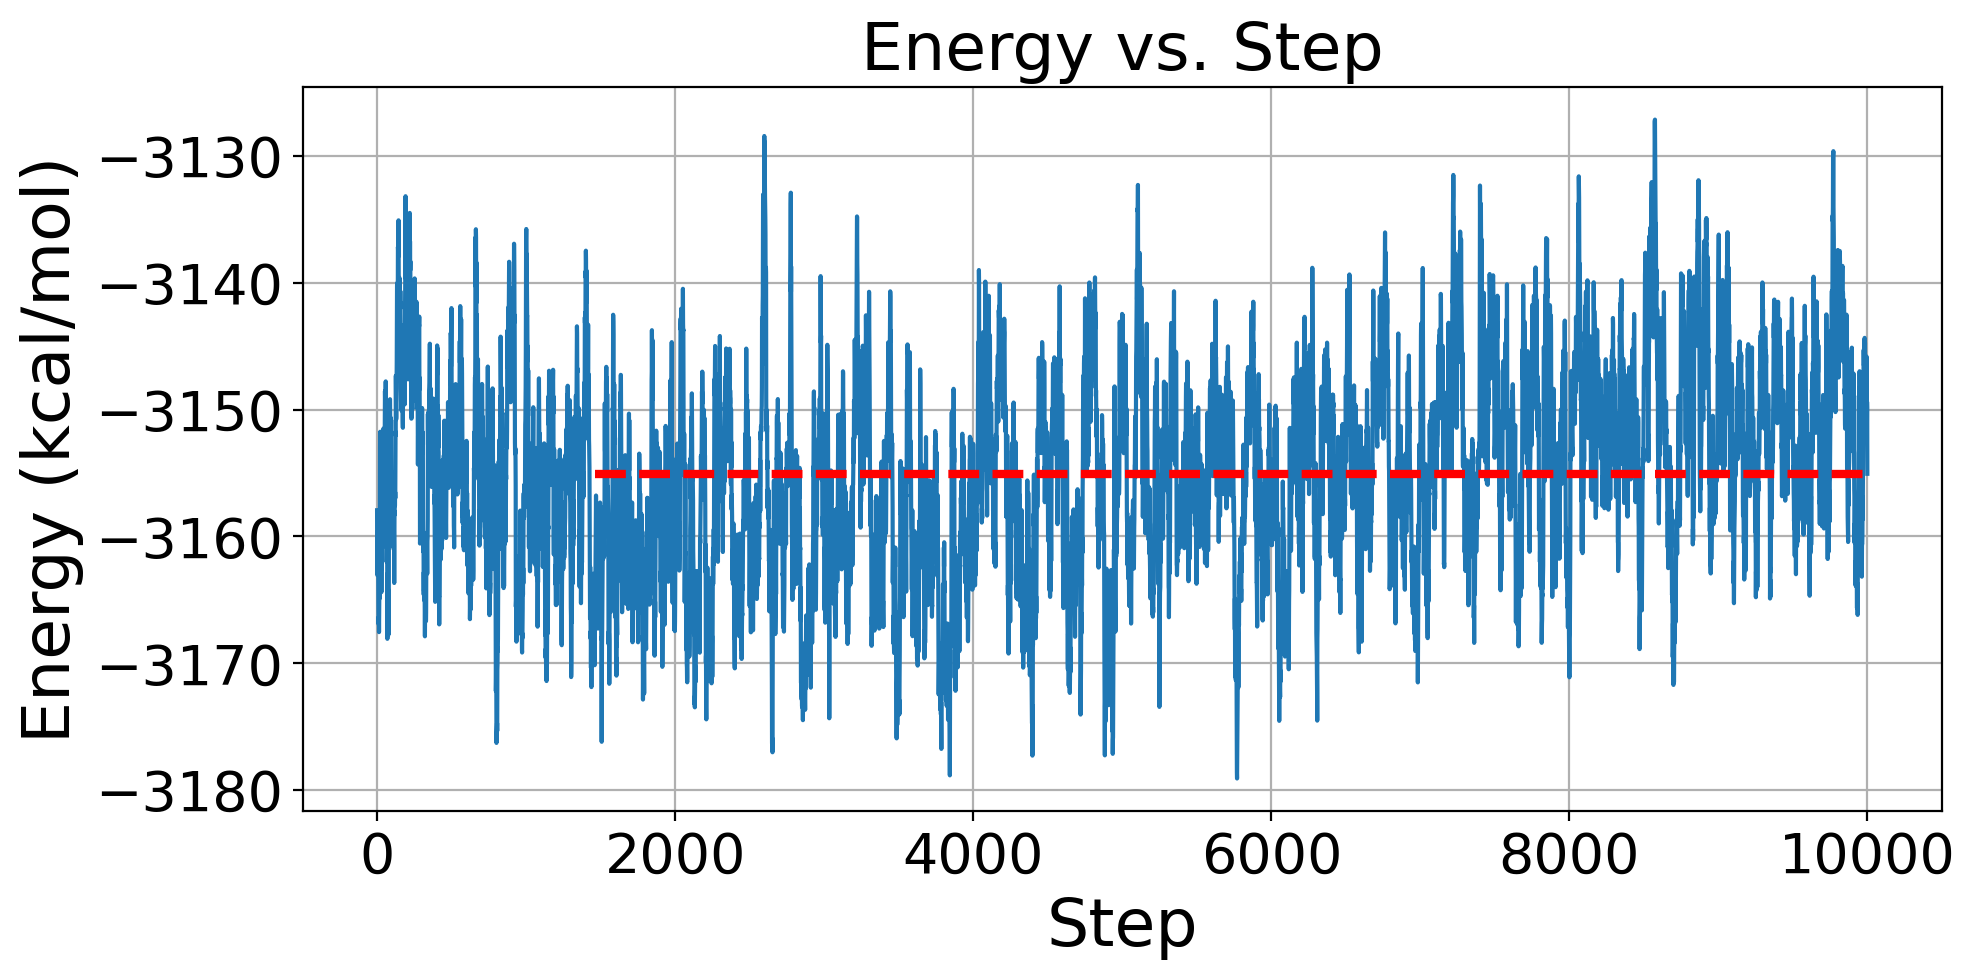

In [456]:



fig = plt.figure(figsize=(10, 5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(E)
ax.set_xlabel("Step", fontsize=24)
ax.set_ylabel("Energy (kcal/mol)", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
_, _, tcutoff = actime(E)
mu = np.mean(E[tcutoff:])

ax.hlines(mu, tcutoff, steps, color="red", linestyle="--", lw=3)

ax.set_title("Energy vs. Step", fontsize=24)
ax.grid()
plt.tight_layout()
plt.savefig("Energy.png", dpi=200)

73


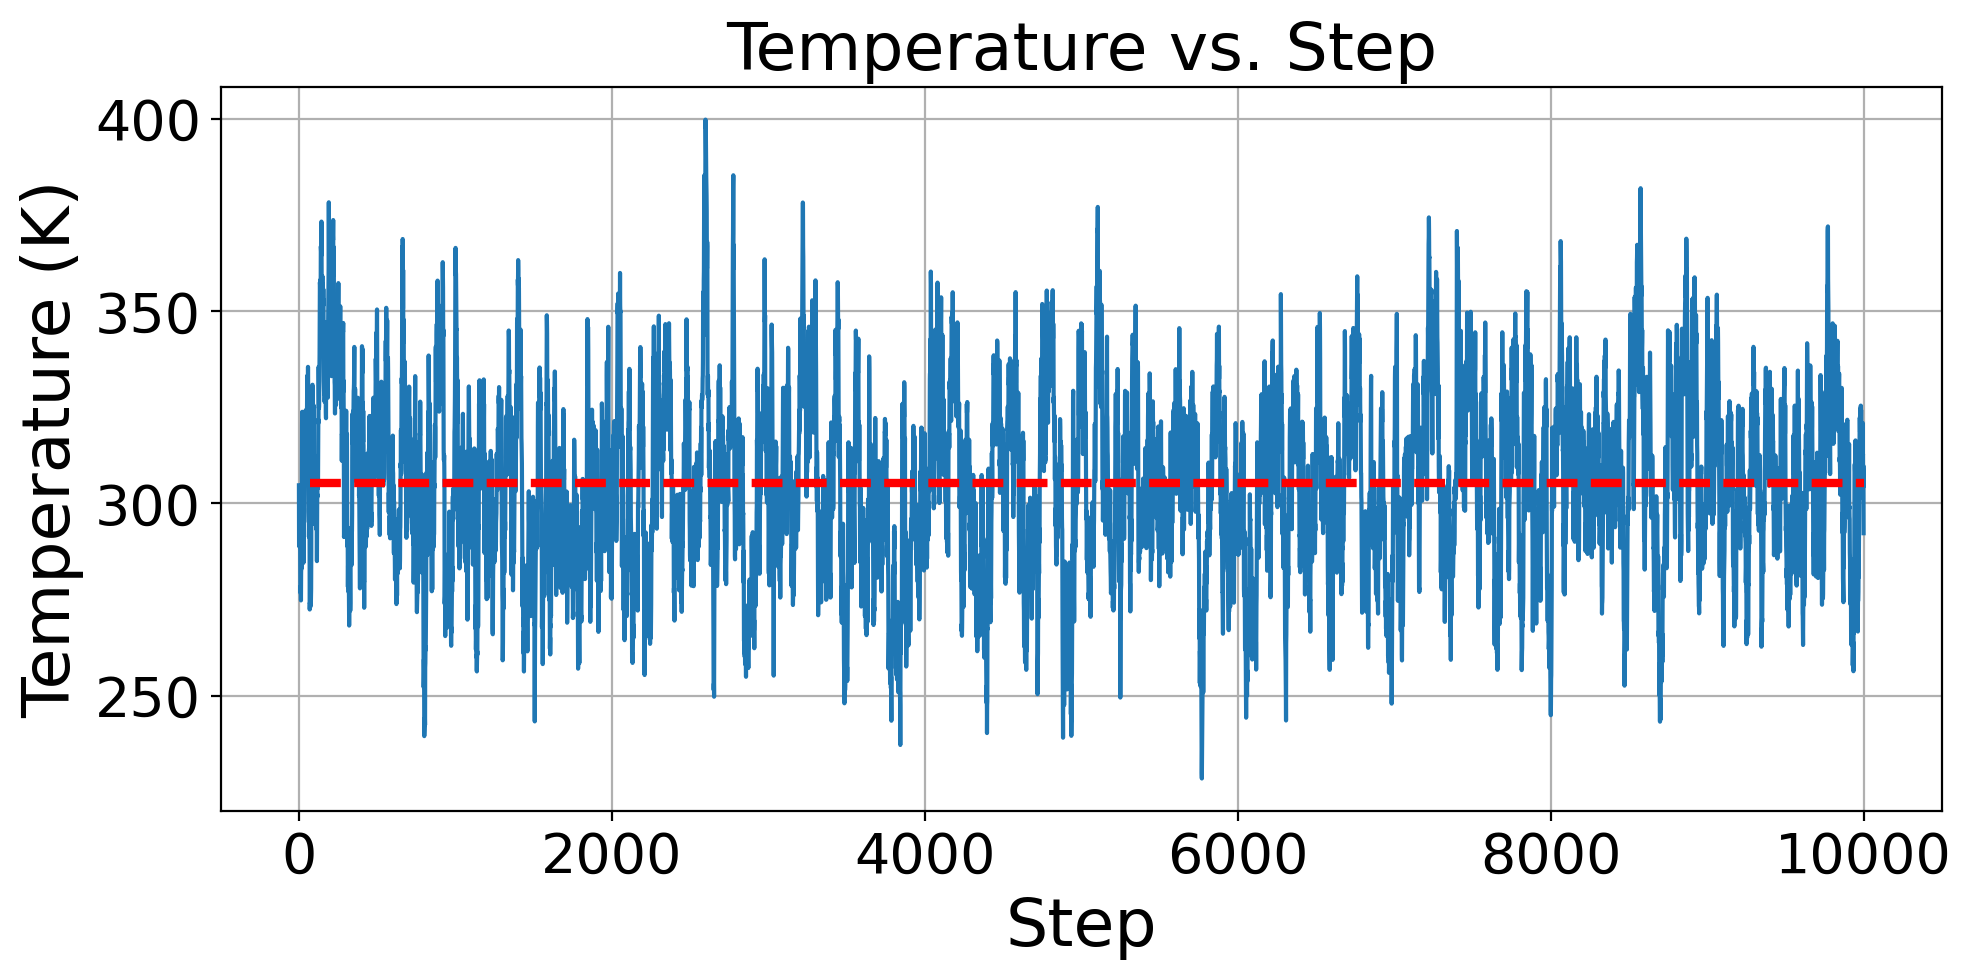

In [457]:
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(T/kb)

_, _, tcutoff = actime(T)
print(tcutoff)
mu = np.mean(T[tcutoff:]/kb)
ax.hlines(mu, tcutoff, steps, color="red", linestyle="--", lw=3)
ax.set_xlabel("Step", fontsize=24)
ax.set_ylabel("Temperature (K)", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title("Temperature vs. Step", fontsize=24)
ax.grid()
plt.tight_layout()
plt.savefig("Temperature.png", dpi=200)

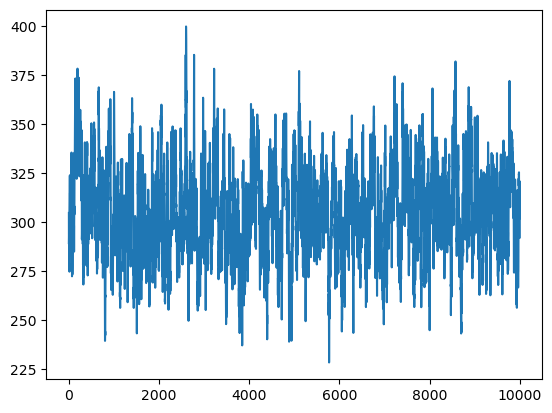

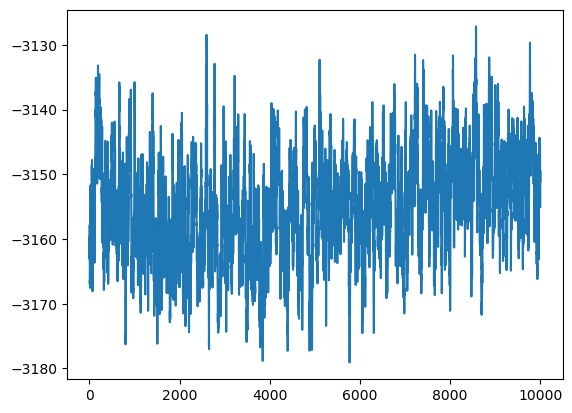

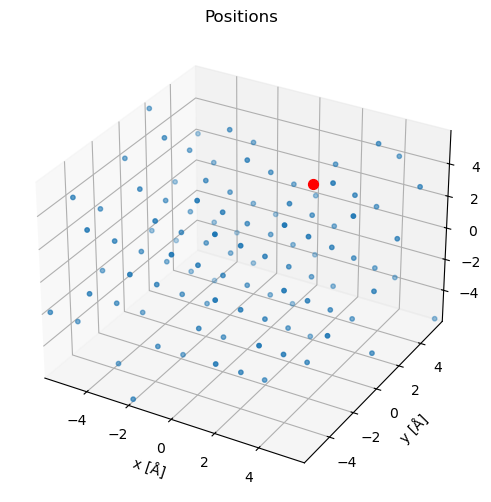

In [426]:

naturalT = T / kb

plt.plot(naturalT)
plt.show()
plt.plot(E)
plt.show()
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
ax.set_xlabel("x [Å]")
ax.set_ylabel("y [Å]")
ax.set_zlabel("T [Å]")
ax.set_title("Positions")
ax.set_zlim(-L / 2, L / 2)
ax.set_xlim(-L / 2, L / 2)
ax.set_ylim(-L / 2, L / 2)
ax.scatter(Rs[0, :, 0], Rs[0, :, 1], Rs[0, :, 2], s=10)
ax.scatter(RsHydrogen[-1, 0], RsHydrogen[-1, 1], RsHydrogen[-1, 2], s=50, c="r")
plt.show()

In [415]:
Rs[0, :, 0][:Nmat] / (L / 2)

array([-1.33240574e-04,  9.99735687e-01,  3.34446489e-01,  9.99874207e-01,
       -9.98961437e-01, -9.99979339e-01, -9.99715251e-01, -6.66263422e-01,
       -6.67639754e-01, -9.99994578e-01, -3.33799521e-01, -6.66322757e-01,
       -3.33315255e-01,  6.65245673e-01,  6.30535656e-04, -6.66818172e-01,
       -6.66403698e-01, -9.99246363e-01,  3.33189742e-01, -9.99258185e-01,
       -6.01736881e-04, -6.65899882e-01, -9.99894718e-01,  7.48019946e-04,
        6.67225091e-01, -3.40782392e-04, -6.65413911e-01,  6.67523224e-01,
        1.41087122e-05,  8.81934918e-04, -3.69074410e-04,  9.99307966e-01,
        9.99398558e-01,  6.66834390e-01,  3.32892851e-01, -8.48724036e-04,
       -2.60629779e-04, -4.91946935e-04, -6.66553523e-01,  6.67166158e-01,
        6.66087098e-01, -6.67171395e-01,  3.32707484e-01,  3.33615417e-01,
       -3.33853502e-01, -3.34256789e-01, -6.66694893e-01, -1.30472783e-03,
        1.61270737e-03,  7.46380233e-04, -6.67391388e-01,  6.65964344e-01,
       -3.32718851e-01, -

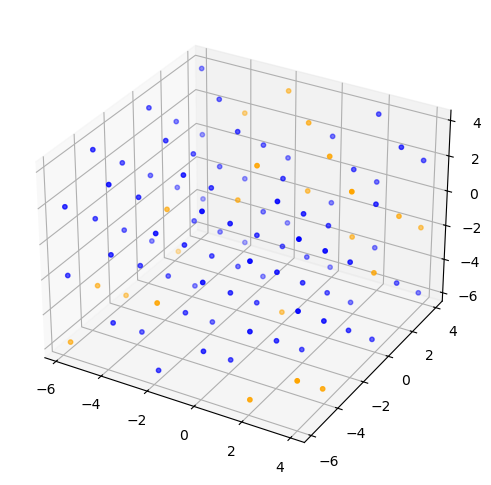

In [406]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
ax.scatter(
    Rs[0, :, 0][Nmat:],
    Rs[0, :, 1][Nmat:],
    Rs[0, :, 2][Nmat:],
    s=10,
    color="orange",
    label="Al",
)
ax.scatter(
    Rs[0, :, 0][:Nmat],
    Rs[0, :, 1][:Nmat],
    Rs[0, :, 2][:Nmat],
    s=10,
    color="blue",
    label="Cu",
)

In [416]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("T")
ax.set_title("Positions")
# ax.set_zlim(-L / 2 * 0.7, L / 2 * 0.7)
# ax.set_xlim(-L / 2 * 0.7, L / 2 * 0.7)
# ax.set_ylim(-L / 2 * 0.7, L / 2 * 0.7)
plt.close()


def animate(i):
    ax.clear()
    ax.set_xlabel("x [Å]")
    ax.set_ylabel("y [Å]")
    ax.set_zlabel("z [Å]")
    ax.set_title(f"Position at t = {i:.2f}")
    ax.set_zlim(-L / 2 * 1, L / 2 * 1)
    ax.set_xlim(-L / 2 * 1, L / 2 * 1)
    ax.set_ylim(-L / 2 * 1, L / 2 * 1)
    x, y, z = Rs[i, :, 0], Rs[i, :, 1], Rs[i, :, 2]
    xh, yh, zh = RsHydrogen[i, 0], RsHydrogen[i, 1], RsHydrogen[i, 2]

    mask = np.logical_or.reduce(
        (
            x > L / 2 * 0.9999,
            x < -L / 2 * 0.9999,
            y > L / 2 * 0.9999,
            y < -L / 2 * 0.9999,
            z > L / 2 * 0.9999,
            z < -L / 2 * 0.9999,
        )
    )

    # mask = (x > L/2 * 1.0 )
    ax.scatter(xh, yh, zh, s=30, c="r")
    ax.scatter(x[~mask][:Nmat], y[~mask][:Nmat], z[~mask][:Nmat], s=30, label="Cu")
    surf = ax.scatter(
        x[~mask][Nmat:],
        y[~mask][Nmat:],
        z[~mask][Nmat:],
        s=30,
        label="Al",
        color="orange",
    )
    ax.legend()
    return surf


frames = np.arange(0, steps, 10)
frames = np.append(frames, steps - 1)
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100)
HTML(anim.to_html5_video())

In [125]:
RHydrogen = PBC(R0[0, 0:3] + a / 2, L)
print(RHydrogen)

[-3.863 -3.863 -3.863]


In [328]:
dr = a / 4
offsets = np.array(
    [
        [dr, dr, dr],
        [-dr, dr, dr],
        [dr, -dr, dr],
        [dr, dr, -dr],
        [-dr, -dr, -dr],
        [dr, -dr, -dr],
        [-dr, dr, -dr],
        [-dr, -dr, dr],
    ]
)

steps = 1000
num_steps = 10
min_energies = []
H_path = []
N = R0.shape[0]
RH = PBC(R0[idx, 0:3] + a / 2, L=L)
T0 = 0.6
for j in range(num_steps):
    H_path.append(copy.deepcopy(RH.tolist()))
    energies = []
    for i in range(offsets.shape[0]):
        RH_curr = PBC(RH + offsets[i], L)

        (
            E,
            P,
            T,
            Vs,
            Rs,
            RsHydrogen,
            EsHydrogen,
            PsHydrogen,
            TsHydrogen,
            VsHydrogen,
        ) = simulateMD_alloy(
            a,
            R0,
            RH_curr,
            L,
            T0,
            Mmat,
            Msol,
            MH,
            Amat,
            Bmat,
            Ams,
            Bms,
            Asol,
            Bsol,
            AHmat,
            AHsol,
            BHmat,
            BHsol,
            steps,
            h,
            rc,
            thermostat=True,
            p=0.05,
            T_bath=T0,
        )

        _, _, tcutoff = actime(E)
        energies.append(np.mean(E[tcutoff:]))

    print(energies)
    energies = np.array(energies)
    arg = np.nanargmin(energies)
    e_min = energies[arg]
    RH = PBC(RH + offsets[arg], L)  # a/4 in some (+-x, +-y, +-z)

    while RH.tolist() in H_path:
        energies = np.delete(energies, arg)
        arg = np.nanargmin(energies)
        e_min = energies[arg]
        RH = PBC(RH + offsets[arg], L)

    min_energies.append(e_min)

[-2781.4021281710698, -2778.234417020989, -2768.12227207663, -2776.5103634390784, -2771.007976934138, -2763.381369332166, -2784.278973936988, -2755.4858615786065]


/var/folders/3_/596gx0f10xg46rczf6hpm5bm0000gn/T/ipykernel_13325/3358543772.py:328: RuntimeWarning: divide by zero encountered in power
  force = 12 * A * distance_table**-13 - 6 * B * distance_table**-7
/var/folders/3_/596gx0f10xg46rczf6hpm5bm0000gn/T/ipykernel_13325/3358543772.py:328: RuntimeWarning: invalid value encountered in subtract
  force = 12 * A * distance_table**-13 - 6 * B * distance_table**-7
/var/folders/3_/596gx0f10xg46rczf6hpm5bm0000gn/T/ipykernel_13325/3358543772.py:291: RuntimeWarning: divide by zero encountered in power
  sixth = r**-6
/var/folders/3_/596gx0f10xg46rczf6hpm5bm0000gn/T/ipykernel_13325/3358543772.py:292: RuntimeWarning: invalid value encountered in subtract
  v = A * sixth**2 - B * sixth


[nan, -3189.565531662392, -3153.728634200461, -3174.274245106399, -3155.206158085781, nan, nan, 1.0210435029653725e+47]
[-2869.315364294598, -2779.0220186010542, -2778.234417020989, -2852.35596592203, -2772.7305608469355, -2784.278973936988, -2774.837955610253, -2771.7611964750504]
[nan, -3173.910970707261, -3174.61118222792, -3188.2909216748676, -3189.565531662392, nan, nan, nan]
[-3188.2909216748676, nan, nan, nan, nan, -3174.274245106399, -3174.455243486576, -3189.565531662392]
[-2849.317427506618, -2869.315364294598, -2781.4021281710698, -2850.3262009506047, -2784.278973936988, -2776.5103634390784, -2852.35596592203, -2778.234417020989]
[nan, -3174.61118222792, -3158.1810453778794, -3186.6249962742636, -3153.728634200461, nan, nan, nan]
[-2757.653968301872, -2849.317427506618, -2766.119804624091, -2755.3204006171145, -2776.5103634390784, -2854.305057121533, -2850.3262009506047, -2781.4021281710698]
[nan, -3186.6249962742636, -3172.36578066618, -3169.874899211678, -3173.151060064403

In [270]:
print(min_energies)

[-2853.1243051136566, -3169.224122375997, -3168.015438006934, -2851.736457271333, -2847.4553895949493, -3183.6502352627012, -2851.736457271333, -3183.257768403529, -3153.8985357731963]


In [267]:
T0 / 0.0019872041

5.032195736713708

we have ```x```

In [495]:
fig = plt.figure(figsize=(8, 6), dpi=200)
ax = plt.axes(projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("T")
ax.set_title("Positions")
ax.set_zlim(-L / 2, L / 2)
ax.set_xlim(-L / 2, L / 2)
ax.set_ylim(-L / 2, L / 2)
plt.close()


def animate(i):
    ax.clear()

    x, y, z = R0[:, 0], R0[:, 1], R0[:, 2]

    ax.scatter(x[:Nmat], y[:Nmat], z[:Nmat], s=80, label="Cu")
    ax.scatter(x[Nmat:], y[Nmat:], z[Nmat:], s=80, label="Al", color="orange")

    ax.set_xlabel("x [Å]", fontsize=18, labelpad = 7)
    ax.set_ylabel("y [Å]", fontsize=18, labelpad = 7)
    ax.set_zlabel("z [Å]", fontsize=18, labelpad = 7)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_zlim(-L / 2 * 1, L / 2 * 1)
    ax.set_xlim(-L / 2 * 1, L / 2 * 1)
    ax.set_ylim(-L / 2 * 1, L / 2 * 1)


    if i % 3 == 0:
        i = int(i / 3)

        surf = ax.scatter(
            H_path[i][0], H_path[i][1], H_path[i][2], s=50, c="r", label="H"
        )
        ax.legend(prop={'size': 16}, loc = 'upper left', bbox_to_anchor=(-.22, .6))
        return surf

    elif i % 3 == 1:
        i = int((i - 1) / 3)
        surf = ax.scatter(
            H_path[i][0], H_path[i][1], H_path[i][2], s=50, c="r", label="H"
        )
        for offset in offsets:
            pos = PBC(H_path[i] + offset, L)
            ax.scatter(pos[0], pos[1], pos[2], s=30, c="green", alpha=0.5, zorder=10)
        ax.legend(prop={'size': 16}, loc = 'upper left', bbox_to_anchor=(-.22, .6))
        return surf

    elif i % 3 == 2:  # < len(H_path) - 1:
        i = int((i - 1) / 3)
        ax.scatter(H_path[i][0], H_path[i][1], H_path[i][2], s=50, c="r", label="H")
        surf = ax.scatter(
            H_path[i + 1][0], H_path[i + 1][1], H_path[i + 1][2], s=30, c="green"
        )
        ax.legend(prop={'size': 16}, loc = 'upper left', bbox_to_anchor=(-.22, .6))
        return surf


frames = np.arange(0, len(H_path) * 3 - 2, 1)
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=600)
HTML(anim.to_html5_video())

In [331]:
len(H_path)

10

[-2853.1243051136566, -3169.224122375997, -3168.015438006934, -2851.736457271333, -2847.4553895949493, -3183.6502352627012, -2851.736457271333, -3183.257768403529, -3153.8985357731963]


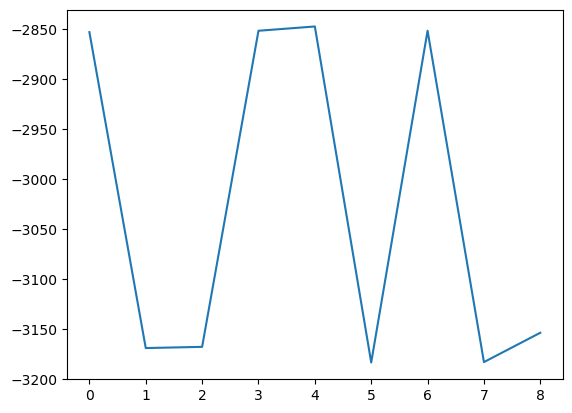

In [272]:
print(min_energies)
plt.plot(min_energies)
from scipy.signal import savgol_filter

In [259]:
print(H_path[7])
print(H_path[8])

[0.9657499999999998, -2.8972500000000005, 4.828749999999999]
[0.9657499999999998, -2.8972500000000005, -4.828750000000001]


In [161]:
R0[0, 0:3]
R0[1, 0:3]

array([-5.7945, -5.7945, -1.9315])

In [181]:
H_path

[array([-3.863, -3.863, -3.863]), array([-2.89725, -4.82875, -4.82875])]

In [177]:
H_path[-1] + offsets[0]

array([-1.9315, -3.863 , -3.863 ])

In [184]:
for row in R0[:, 0:3]:
    print(np.abs(row - PBC(H_path[-1] + offsets[0], L)))
    if np.all(H_path[-1] + offsets[0] == row):
        print("yes")

[3.863  1.9315 1.9315]
[3.863  1.9315 1.9315]
[5.7945 1.9315 3.863 ]
[3.863  5.7945 1.9315]
[4.4408921e-16 1.9315000e+00 1.9315000e+00]
[1.9315 7.726  1.9315]
[4.4408921e-16 5.7945000e+00 5.7945000e+00]
[4.4408921e-16 0.0000000e+00 0.0000000e+00]
[4.4408921e-16 1.9315000e+00 1.9315000e+00]
[1.9315 0.     5.7945]
[3.863  1.9315 1.9315]
[1.9315 7.726  1.9315]
[5.7945 7.726  1.9315]
[3.863  1.9315 5.7945]
[4.4408921e-16 1.9315000e+00 5.7945000e+00]
[3.863  1.9315 5.7945]
[4.4408921e-16 5.7945000e+00 1.9315000e+00]
[3.863  1.9315 1.9315]
[3.863 0.    0.   ]
[1.9315 7.726  5.7945]
[3.863  1.9315 1.9315]
[4.4408921e-16 7.7260000e+00 0.0000000e+00]
[3.863  5.7945 1.9315]
[3.863  5.7945 1.9315]
[3.863  5.7945 5.7945]
[3.863  5.7945 1.9315]
[1.9315 0.     1.9315]
[1.9315 3.863  5.7945]
[1.9315 3.863  5.7945]
[1.9315 3.863  1.9315]
[1.9315 0.     1.9315]
[1.9315 5.7945 3.863 ]
[4.4408921e-16 0.0000000e+00 3.8630000e+00]
[3.863  1.9315 1.9315]
[1.9315 0.     1.9315]
[1.9315 0.     1.9315]
[1.9315

In [167]:
R0[:, 0:3]

array([[-5.79450000e+00, -5.79450000e+00, -5.79450000e+00],
       [-5.79450000e+00, -5.79450000e+00, -1.93150000e+00],
       [ 3.86300000e+00, -1.93150000e+00, -2.22044605e-16],
       [-5.79450000e+00,  1.93150000e+00, -5.79450000e+00],
       [-1.93150000e+00, -1.93150000e+00, -5.79450000e+00],
       [-2.22044605e-16,  3.86300000e+00, -5.79450000e+00],
       [-1.93150000e+00,  1.93150000e+00,  1.93150000e+00],
       [-1.93150000e+00, -3.86300000e+00, -3.86300000e+00],
       [-1.93150000e+00, -5.79450000e+00, -5.79450000e+00],
       [-3.86300000e+00, -3.86300000e+00,  1.93150000e+00],
       [-5.79450000e+00, -1.93150000e+00, -5.79450000e+00],
       [-3.86300000e+00,  3.86300000e+00, -5.79450000e+00],
       [ 3.86300000e+00,  3.86300000e+00, -5.79450000e+00],
       [-5.79450000e+00, -1.93150000e+00,  1.93150000e+00],
       [-1.93150000e+00, -5.79450000e+00,  1.93150000e+00],
       [ 1.93150000e+00, -5.79450000e+00,  1.93150000e+00],
       [-1.93150000e+00,  1.93150000e+00